In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import pwlf
import re
from scipy import stats
sns.set()
plt.style.use('seaborn')
pd.options.plotting.backend = "plotly"
plt.rcParams["figure.figsize"] = (16, 8)
sns.set_palette("bright")
#sns.set_style('whitegrid')
sns.set(style="ticks")

In [2]:
# put months in dataframe that have no values
def fill_missing_months(drug_df):
    beg_year, end_year = 2008, 2022
    beg_month, end_month = 1, 12
    for year in range(beg_year, end_year+1):
        for month in range(beg_month, end_month+1):
            if month<10:
                month_str = '0'+str(month)
            else:
                month_str = str(month)
            month_year = str(year) + '-' + month_str
            if month_year in drug_df['month-year'].unique():
                #print(month_year)
                continue
            new_row = pd.DataFrame({
                'month' : [month_str],
                'year' : [str(year)],
                'month-year' : [month_year],
                'comments' : [0],
                'views' : [0],
                'url' : [''],
                'title' : ['something'],
                'username' : ['something]'],
                'user_url' : [''],
                'thread_id' : [0],
                'forum' : [''],
            }, index = [len(drug_df)])
            drug_df = drug_df.append(new_row)
    return drug_df

In [3]:
def search_drug_pattern(search_word):
    '''creates regex search pattern from a search word 
    for example 3mmc search will look for 
    3mmc 3-mmc 3 mmc and 3MMC 3 MMC 3-MMC
    '''
    search_word = search_word.strip() # remove leadning and trailing white spaces
    pattern = r'\s+' # one white space or more
    search_word=re.sub(pattern,"-", search_word)    
    pattern = r'([0-9]+)' # one dash or more
    search_word = re.sub(pattern, r"\1-", search_word)
    pattern = r'-+' # one dash or more
    search_word = re.sub(pattern,"-", search_word)
 
    pattern = search_word.replace("-","\s*\-*")
    pattern = '\\b'+pattern+'\\b'
    pattern = re.compile(pattern, flags=re.IGNORECASE)  
    return pattern

In [4]:
# return only rows where one of the drug_names occur; create rows for months with 0 mentions
def get_drug_timeseries(drug_names, df):
    drug_df = pd.DataFrame(columns=df.columns)
    df = df[df['date']!='something']
    df['title'] = df['title'].str.lower()
    df['content'] = df['content'].str.lower()
    # run loop to search for every drug name
    for drug_name in drug_names:
        drug_name = drug_name.lower()
        drug_pattern = search_drug_pattern(drug_name)
       
        t_df = df[df['title'].str.contains(drug_name)]
        c_df = df[df['content'].str.contains(drug_name)]
        
        tc_df = pd.concat([t_df,c_df]).drop_duplicates().reset_index(drop=True)
        drug_df = pd.concat([drug_df, tc_df]).drop_duplicates().reset_index(drop=True)
    
    drug_df['month'] = drug_df['date'].apply(lambda x: int(x.split('-')[1]))
    drug_df['year'] = drug_df['date'].apply(lambda x: int(x.split('-')[0]))
    drug_df['month-year'] = drug_df['date'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
    
    drug_df = fill_missing_months(drug_df)
    
    data=drug_df.sort_values(by=['month-year'], ascending=True)

    data['views'] = data['views'].astype('int')
    data['comments'] = data['comments'].astype('int')

    data['month-year'] = data['month-year'].apply(lambda x: datetime.strptime(x, "%Y-%m"))
    data['freq'] = data['views'].map(lambda x: 0 if x == 0 else 1)
    
    data = data.drop(['thread_id','forum','title','content','url','username','user_id','user_url','date']
              ,axis=1)
    return data

In [5]:
# plot yearly data for metric
def get_yearly_graph(data, metric='views'):
    data['year'] = data['year'].astype('str')
    yearly = data.groupby(['year'])[metric].sum().reset_index()
    
    sns.lineplot(x = yearly['year'].astype('str'),
            y = pd.to_numeric(yearly[metric]),
            estimator=sum,
            ci=None,
            color='b',
            label=metric
            )
    plt.title(metric + ' of posts per year')

In [6]:
# apply piecewise regression (& rolling average) and save data to csv
def apply_piecewise_linear_regression(data, drug_name, forum = 'nl'):
    agg_data = pd.DataFrame()
    agg_data['views'] = data.groupby(['month-year'])['views'].sum().reset_index()['views']
    agg_data['comments'] = data.groupby(['month-year'])['comments'].sum().reset_index()['comments']
    agg_data['freq'] = data.groupby(['month-year'])['freq'].sum().reset_index()['freq']
    agg_data['month-year'] = data.groupby(['month-year'])['freq'].sum().reset_index()['month-year']
    data = agg_data

    date_dict = {}
    for i,my in enumerate(list(data['month-year'])):
        if my in date_dict.keys():
            print(my)
        date_dict[my] = i

    for metric in ['views','comments','freq']:
    #for metric in ['views']:
        print("metric : ", metric)
        moving_avg = 'moving-avg-' + metric
        data[moving_avg] = data[metric].rolling(4).mean()
        data[moving_avg] = data[moving_avg].fillna(0)
        model = pwlf.PiecewiseLinFit(np.arange(0,len(date_dict)), list(data[moving_avg]))
        breakpoints = model.fit(12)
        y_pred = model.predict(np.arange(0,len(date_dict)))
        piecewise = 'piecewise-'+metric
        data[piecewise] = y_pred
    
    if forum == 'nl':
        data.to_csv('timeseries/'+drug_name+'.csv', index=False)
    if forum == 'info':
        data.to_csv('timeseries_info/'+drug_name+'.csv', index=False)
    return None

In [7]:
# plot .nl and .info metric data
def plot_two_sources(data1, data2):
    metric = 'views'
    sns.lineplot(x=data1['year'],
            y = pd.to_numeric(data1[metric]),
            estimator=sum,
            ci=None,
            color='b',
            label='source1'
            )
    sns.lineplot(x=data2['month-year'],
                y = pd.to_numeric(data2[metric]),
                estimator=sum,
                ci=None,
                color='orange',
                label='source2'
                )
    plt.xticks(rotation='vertical')
    plt.locator_params(axis='x', nbins=20)
    
    plt.title('views of posts related to ' + '/'.join(drug_names))

In [8]:
# combine three sources of drugsforum.nl and return df
def get_nl_df():
    df1 = pd.read_csv('../../corpus/forums/drugsforumNL/threads/drugs_generaldrugsforumnl_threads.csv',
                     lineterminator='\n')
    df2 = pd.read_csv('../../corpus/forums/drugsforumNL/threads/research_chemicalsdrugsforumnl_threads.csv')
    df3 = pd.read_csv('../../corpus/forums/drugsforumNL/threads/trip_reportsdrugsforumnl_threads.csv',
                     lineterminator='\n')
    return pd.concat([df1, df2, df3], axis=0)    

In [9]:
# return df for drugforums.info
def get_info_df():
    df = pd.read_csv('../../corpus/forums/drugsforumInfo/threads/drugsforuminfo_threads.csv')
    return df

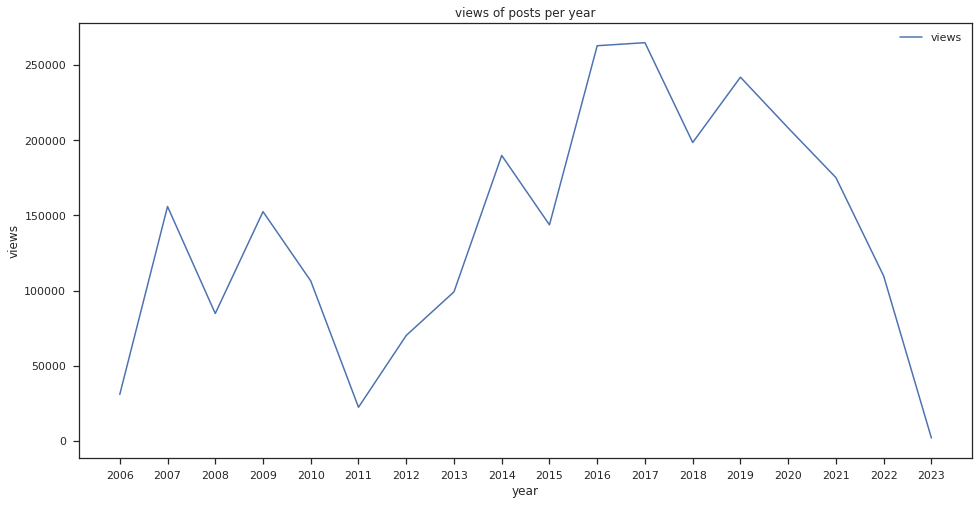

In [10]:
nl_df = get_nl_df()
#drug_names=['3mmc', '3-mmc', '3 mmc']
#drug_names = ['4-fa', '4fa', '4 fa', '4-fmp', '4 fmp', '4fmp']
drug_names = ['2-cb','2cb','2 cb']
nl_data = get_drug_timeseries(drug_names, nl_df)
get_yearly_graph(nl_data, metric='views')

## applying piecewise linear regression to nl & info data

In [24]:
nl_df = get_nl_df()
#drug_names=['3-mmc', '3mmc', '3 mmc']
#drug_names = ['4-fa', '4fa', '4 fa', '4-fmp', '4 fmp', '4fmp']
#drug_names = ['2-cb','2cb','2 cb','2c-b','2c b']
#drug_names = ['4-mmc', '4mmc', '4 mmc', 'mephedrone', 'mefedron']
drug_names = ['4-fma', '4fma', '4 fma']
#drug_names = [ '6-apb', '6 apb', '6apb', 'benzofury', 'benzo fury']
nl_data = get_drug_timeseries(drug_names, nl_df)
pwlr_nl_data = apply_piecewise_linear_regression(nl_data, drug_names[0], forum='nl')

metric :  views
metric :  comments
metric :  freq


In [173]:
info_df = get_info_df()
#drug_names=['3-mmc', '3mmc', '3 mmc']
#drug_names = ['4-fa', '4fa', '4 fa', '4-fmp', '4 fmp', '4fmp']
#drug_names = ['2-cb','2cb','2 cb','2c-b','2c b']
#drug_names = ['4-mmc', '4mmc', '4 mmc', 'mephedrone', 'mefedron']
#drug_names = ['4-fma', '4fma', '4 fma']
info_data = get_drug_timeseries(drug_names, info_df)
pwlr_info_data = apply_piecewise_linear_regression(info_data, drug_names[0], forum='info')

/home/anshita/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/anshita/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



metric :  views
metric :  comments
metric :  freq


## correlation and trimbos data related functions

In [69]:
# return dataframe with trimbos data
def get_trimbos_data():
    data = pd.read_csv('../../corpus/trimbos/trimbos_data.csv')
    data['year'] = data['year'].astype('str')
    data['year'] = data['year'].apply(lambda x: datetime.strptime(x, "%Y"))
    return data

In [70]:
# plot trimbos data and drugforums.nl data in the same graph
# options for metric: views, comments, freq
# options for period: month-year, year
def plot_trimbos_nl_data(trimbos_data, drug_name, metric='views', period='month-year'):
    data = pd.read_csv('timeseries/'+drug_name+'.csv')
    data['year'] = data['month-year'].apply(lambda x: datetime.strptime(x.split('-')[0], "%Y"))
    data['month-year'] = data['month-year'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    
    data = data[data['year'].isin(trimbos_data['year'])]
    
    # set trimbos year to december so that the ending aligns
    if period == 'month-year':
        trimbos_data['year'] = trimbos_data['year'].apply(lambda x: datetime(x.year,12,1))
    
    ax1 = sns.lineplot(x=trimbos_data['year'],
            y = pd.to_numeric(trimbos_data[drug_name]),
            estimator=sum,
            ci=None,
            color='red',
            label='trimbos',
            linewidth = 3
            )
    
    ax1.set(ylabel='Trimbos Drug Sample Data')
    ax1.set(xlabel='Year')
    ax1.legend(loc=(0.005,0.845))
#    ax1.grid(False)
    
    ax2 = plt.twinx()
    ax2.grid(False)
    sns.lineplot(x=data[period],
                y = pd.to_numeric(data[metric]),
                estimator=sum,
                ci=None,
                ax = ax2,
                color='green',
                label='drugforum.nl ' + metric.capitalize(),
                linewidth = 1
                )
    sns.lineplot(x=data[period],
            y = pd.to_numeric(data['moving-avg-' + metric]),
            estimator=sum,
            ci=None,
            ax = ax2,
            color='blue',
            label='drugforum.nl Moving Average ' + metric.capitalize(),
            linewidth = 1
            )
    sns.lineplot(x=data[period],
            y = pd.to_numeric(data['piecewise-' + metric]),
            estimator=sum,
            ci=None,
            ax = ax2,
            color='black',
            linewidth=1.5,
            label='drugforum.nl Piecewise ' + metric.capitalize()
            )
    ax2.lines[2].set_linestyle("--")
    ax2.set(ylabel=metric.capitalize() +' in drugforums.nl')

    plt.xticks(rotation='vertical') 
    plt.title("Trimbos Sample Data and "+ metric +" in drugsforum.nl, from 2012 to 2021, for "+drug_name)
    plt.legend()

In [16]:
# plot trimbos data and drugforums.info data in the same graph
# options for metric: views, comments, freq
# options for period: month-year, year
def plot_trimbos_info_data(trimbos_data, drug_name, metric='views'):
    data = pd.read_csv('timeseries_info/'+drug_name+'.csv')
    data['year'] = data['month-year'].apply(lambda x: datetime.strptime(x.split('-')[0], "%Y"))
    data['month-year'] = data['month-year'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))


    ax1 = sns.lineplot(x=trimbos_data['year'],
            y = pd.to_numeric(trimbos_data[drug_name]),
            estimator=sum,
            ci=None,
            color='b',
            label='trimbos'
            )
    ax1.set(xlabel = 'trimbos test data')
    ax1.legend(loc='upper center')
    ax2 = plt.twinx()
    ax2.grid(False)
    sns.lineplot(x=data['year'],
                y = pd.to_numeric(data[metric]),
                estimator=sum,
                ci=None,
                ax = ax2,
                color='orange',
                label='\ndrugforum'
                )
    plt.xticks(rotation='vertical')    

In [71]:
# print correlation and p-values of a drugforum metric and trimbos data
# options for metric: views, comments, freq
# options for forum: nl, info
def get_trimbos_forum_correlation(trimbos_data, drug_name, metric='views', forum='nl'):
    if forum == 'nl':
        forum_data = pd.read_csv('timeseries/'+drug_name+'.csv')
    else:
        forum_data = pd.read_csv('timeseries_info/'+drug_name+'.csv')
        
    forum_data['year'] = forum_data['month-year'].apply(lambda x: datetime.strptime(x.split('-')[0], "%Y"))
    metric_data = forum_data.groupby('year').agg('sum')[metric]
    moving_avg = forum_data.groupby('year').agg('sum')['moving-avg-'+metric]
    piecewise = forum_data.groupby('year').agg('sum')['piecewise-'+metric]
    data = pd.DataFrame()
    data['trimbos'] = trimbos_data[drug_name]
    data['year'] = trimbos_data['year']
    data = data.merge(metric_data, left_on='year', right_on='year')
    data = data.merge(moving_avg, left_on='year', right_on='year')    
    data = data.merge(piecewise, left_on='year', right_on='year')
    corr, p = stats.pearsonr(data['trimbos'], data[metric])
    print('actual: ', round(corr, 2), round(p, 4))
    corr, p = stats.pearsonr(data['trimbos'], data['moving-avg-'+metric])
    print('rolling: ', round(corr, 2), round(p, 4))
    corr, p = stats.pearsonr(data['trimbos'], data['piecewise-'+metric])
    print('piecewise: ', round(corr, 2), round(p, 4))

## getting correlation with trimbos data & plotting

In [43]:
trimbos_data = get_trimbos_data()
get_trimbos_forum_correlation(trimbos_data, '4-fma', metric='freq', forum='nl')

actual:  0.43 0.21
rolling:  0.4 0.253
piecewise:  0.4 0.2508


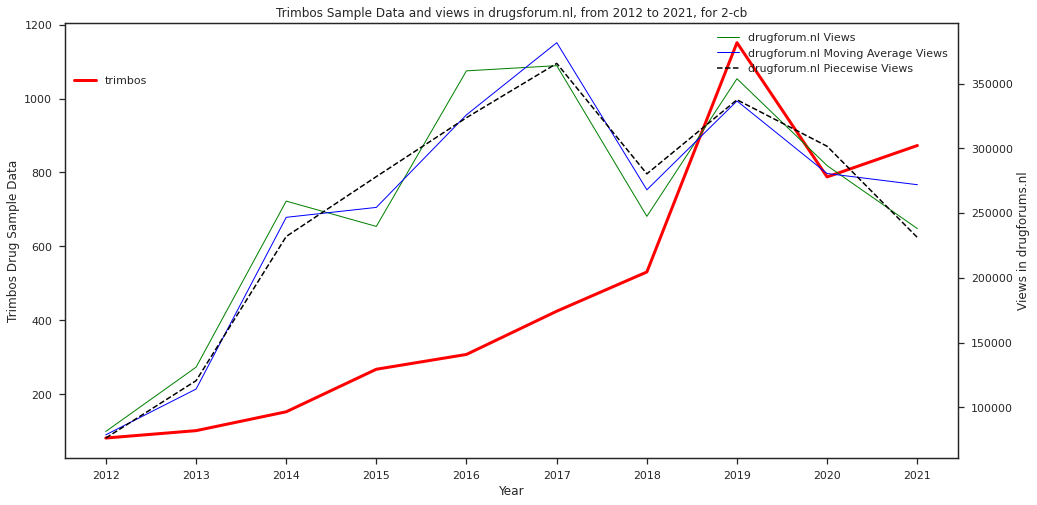

In [30]:
trimbos_data = get_trimbos_data()
plot_trimbos_nl_data(trimbos_data, '2-cb', metric='views', period='year')

In [62]:
trimbos_data = get_trimbos_data()
get_trimbos_forum_correlation(trimbos_data, '4-fma', metric='freq', forum='info')

actual:  -0.13 0.7238
rolling:  -0.16 0.6535
piecewise:  -0.17 0.6325
